# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
import sys
import pandas as pd
from scipy import optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 16
from mpl_toolkits.mplot3d import Axes3D

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#np.set_printoptions(threshold=sys.maxsize)

from HANKmodel import HANKModelClass
from HANKmodel_baseline import HANKModelClass_baseline

# Setup

In [ ]:
#print(model)
model = HANKModelClass(name='two_sector')
model_baseline = HANKModelClass_baseline(name='one_sector')
#model.print_unpack_varlist()

# Step 1: Steady state

### Two-sector model

In [ ]:
model.find_ss(do_print=True)
model.compute_jacs(do_print=False)

par = model.par
ss = model.ss
path = model.path
sim = model.sim


#### Tests

In [ ]:
'''
# HH Transition path
model.test_hh_path()
#Full transition path
model.test_path()
#Show Jacobians
model.test_jacs(s_list=[50,100,150])
'''

## Steady state characteristics:

In [ ]:
print(f'Average expenditures share on luxuries (in the data = 51.8%) = {(ss.C_L*ss.Q/(ss.P*ss.C)):8.4f}')
print(f'Average Subsistence share of expenditures (in the data = 22.4%) = {(par.c_bar/(ss.P*ss.C)):8.4f}')
print(f'Lowest income household subsistence share of expenditures (in the data = 43,5%) = {(par.c_bar/(ss.P*np.average(ss.c[0,0,0]))):8.4f}')
print(f'Average expenditures share on necessities for the lowest income households (in the data = 70.5%): = {(np.average(ss.c_N[0,0,0]))/(ss.P*np.average(ss.c[0,0,0])):8.4f}')
print(f'Average expenditures share on necessities (in the data = 48.2%) = {(ss.C_N/(ss.P*ss.C)):8.4f}')
print(f'Average expenditures share on necessities, net of subsistence (in the data = 33.2%) = {(ss.C_HAT_N_hh/(ss.P*ss.C)):8.4f}')
print(f'wage share, necessities production: (in the data = 37.3%) = {(ss.N_N*ss.w_N/(ss.M_N*ss.pm_N+ss.N_N*ss.w_N)):8.4f}')
print(f'wage share, luxuries production: (in the data =69.2%) = {(ss.N_L*ss.w_L/(ss.M_L*ss.pm_L+ss.N_L*ss.w_L)):8.4f}')

MPCs for different values of Chi and c_bar

In [ ]:
'''
model_MPC = model.copy()

c_bar_list = [0.0, 0.025, 0.05, 0.075, 0.10]
chi_list = [0.0, 0.025, 0.05, 0.075, 0.10]

MPC_matrix = np.empty(shape=(len(c_bar_list),len(chi_list)))

for i,c_bar in enumerate(c_bar_list):
    model_MPC.par.c_bar = c_bar
    
    for j,chi in enumerate(chi_list):
        model_MPC.par.chi = chi
        
        model_MPC.find_ss()

        model_MPC.MPC = np.zeros(model_MPC.ss.D.shape)
        m_diff = (1+model_MPC.ss.r)*model_MPC.par.a_grid[np.newaxis,np.newaxis,1:]-(1+model_MPC.ss.r)*model_MPC.par.a_grid[np.newaxis,np.newaxis,:-1]
        model_MPC.MPC[:,:,:-1] = (model_MPC.ss.c[:,:,1:]-model_MPC.ss.c[:,:,:-1])/m_diff
        model_MPC.MPC[:,:,-1] = model_MPC.MPC[:,:,-1] # assuming constant MPC at end
        model_MPC.mean_MPC = np.sum(model_MPC.MPC*model_MPC.ss.D)
        model_MPC.mean_MPC_ann = 1-(1-model_MPC.mean_MPC)**4
        MPC_matrix[j,i] = model_MPC.mean_MPC_ann
        print(f'mean MPC - c_bar = {c_bar:.3f}, chi = {chi:.3f} : {model_MPC.mean_MPC:.3f} [annual: {model_MPC.mean_MPC_ann:.3f}]')

df_mpc = pd.DataFrame(MPC_matrix, columns=c_bar_list, index=chi_list)
print(df_mpc.to_latex())
'''

Steady state values

In [ ]:
var_list = ['Y','N','M','mc','d','C','w','pm'] 
var_dict = vars(ss)
var_dict_baseline = vars(model_baseline.ss)
values_N = [round(var_dict[i+'_N'],3) for i in var_list]
values_L = [round(var_dict[i+'_L'],3) for i in var_list]
values_baseline = [round(var_dict_baseline[i],3) for i in var_list]
ss_values_df = pd.DataFrame(list(zip(values_baseline,values_N,values_L)), columns=['One-Sector','Sector N','Sector L'], index=var_list)
print(ss_values_df.to_latex())


Steady State graphs

In [ ]:
#'''
a_max = 500

MPC = np.zeros(ss.D.shape)
m_diff = (1+ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
MPC[:,:,:-1] = (ss.c[:,:,1:]-ss.c[:,:,:-1])/m_diff
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*ss.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'Mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')


fig = plt.figure(figsize=(3*6,2*4),dpi=100)

# a. income/productivity
ax = fig.add_subplot(2,3,1)
ax.set_title('Productivity')
y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])
ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(2,3,2)
ax.set_title('Savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

# c. MPC
I = par.a_grid < a_max
ax = fig.add_subplot(2,3,3)
ax.set_title('Marginal Propensity to Consume')
for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],MPC[0,i_z,I],label=f'i_z = {i_z}')
ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$MPC$')
ax.set_xscale('symlog')

# D. labor supply
I = par.a_grid < a_max
ax = fig.add_subplot(2,3,4)
ax.set_title('Labor Supply')
for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $ell_{t}$')
#ax.set_xscale('symlog')

# a. necessity consumption share
I = model.par.a_grid < a_max
ax = fig.add_subplot(2,3,5)
ax.set_title('Consumption Share (Necessities)')
for i_z in [0,model.par.Nz//2,model.par.Nz-1]:
    ax.plot(model.par.a_grid[I],model.ss.c_N[0,i_z,I]/(model.ss.P*model.ss.c[0,i_z,I]),label=f'i_z = {i_z}')
#ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{N,t}$')
#ax.set_xscale('symlog')

# a. luxury consumption share
I = model.par.a_grid < a_max
ax = fig.add_subplot(2,3,6)
ax.set_title('Consumption Share (Luxuries)')
for i_z in [0,model.par.Nz//2,model.par.Nz-1]:
    ax.plot(model.par.a_grid[I],model.ss.Q*model.ss.c_L[0,i_z,I]/(model.ss.P*model.ss.c[0,i_z,I]),label=f'i_z = {i_z}')

#ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{L,t}$')
#ax.set_xscale('symlog')

fig.tight_layout()
#'''

# Step 3a: Find non-linear transition path

## Plot transitions

## Find transition path 1 - Monetary Policy shock

In [ ]:
### 2 sector MP shock ###
par.jump_istar = 0.01 # 25 BP Monetary policy shock
par.jump_pm_N     = 0.0 # cost push shock
model.find_transition_path(do_print=False) #all

paths_hh = ['i','pi','r','Q','ELL_hh','C_hh','C_N_hh','C_L_hh','tau','w_N']
paths_firms =['pi_N','pi_L','N_N','N_L','M_N','M_L','d_N','d_L']
lvl_value = ['i','pi_L','pi_N','r','pi','tau'] #Show all push

### Push shock ###
model_push = model.copy()
model_push.par.jump_istar = 0.00 # 25 BP Monetary policy shock
model_push.par.jump_pm_N     = 0.01*model_push.ss.Q # cost push shock
model_push.find_transition_path()


In [ ]:
# Household stuff
model.compare_IRFs([model,model_push],['MP shock','Cost-push shock'],paths_hh,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=4)

In [ ]:
# Firm stuff
model.compare_IRFs([model,model_push],['MP shock','Cost-push shock'],paths_firms,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=4)

In [ ]:
'''
fig = plt.figure(figsize=(3*6,3*4),dpi=100)

ax = fig.add_subplot(3,3,1)
ax.set_title('Real interest rate')
ax.plot((model.path.r[0,:50]-ss.r)*100,label=f'Two-sector')
ax.plot((model_baseline.path.r[0,:50]-ss.r)*100,label=f'One-sector')
ax.set_ylabel('Dilf to s.s.')
ax.legend(frameon=True)

ax = fig.add_subplot(3,3,2)
ax.set_title('Aggregate Inflation')
ax.plot((model.path.pi[0,:50]-ss.pi)*100,label=f'Two-sector')
ax.plot((model_baseline.path.pi[0,:50]-ss.pi)*100,label=f'One-sector')

ax = fig.add_subplot(3,3,3)
ax.set_title('Aggregate Labor')
ax.plot((model.path.ELL_hh[0,:50]-ss.ELL_hh)/ss.ELL_hh*100,label=f'Two-sector')
ax.plot((model_baseline.path.ELL_hh[0,:50]-model_baseline.ss.ELL_hh)/model_baseline.ss.ELL_hh*100,label=f'Two-sector')

ax = fig.add_subplot(3,3,4)
ax.set_title('Aggregate Consumption')
ax.plot((model.path.C_hh[0,:50]-ss.C)/ss.C*100,label=f'Two-sector')
ax.plot((model_baseline.path.C_hh[0,:50]-model_baseline.ss.C)/model_baseline.ss.C*100,label=f'Two-sector')
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,5)
ax.set_title('Consumption: Necessities')
ax.plot((model.path.C_N_hh[0,:50]-ss.C_N)/ss.C_N*100,label=f'Two-sector')

ax = fig.add_subplot(3,3,6)
ax.set_title('Consumption: Luxuries')
ax.plot((model.path.C_L_hh[0,:50]-ss.C_L)/ss.C_L*100,label=f'Two-sector')

ax = fig.add_subplot(3,3,7)
ax.set_title('Necessities price')
ax.plot((model.path.p_N[0,:50]-ss.p_N)/ss.p_N*100,label=f'Two-sector')

ax = fig.add_subplot(3,3,8)
ax.set_title('Luxuries price')
ax.plot((model.path.p_L[0,:50]-ss.p_L)/ss.p_L*100,label=f'Two-sector')

ax = fig.add_subplot(3,3,9)
ax.set_title('Relative prices, Q')
ax.plot((model.path.Q[0,:50]-ss.Q)/ss.Q*100,label=f'Two-sector')
'''

### Overall Consumption decomposition: By wealth level

['Direct effects', 'r']

['Price effects', 'Q', 'P', 'p_L', 'p_N']

['Income effects', 'N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['w_N', 'd_N', 'd_L', 'tau']

None

all

['Direct effects', 'r']

['Price effects', 'Q', 'P', 'p_L', 'p_N']

['Income effects', 'N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['w_N', 'd_N', 'd_L', 'tau']

None

all

['Direct effects', 'r']

['Price effects', 'Q', 'P', 'p_L', 'p_N']

['Income effects', 'N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['w_N', 'd_N', 'd_L', 'tau']

None

al

Text(0, 0.5, '% diff to s.s.')

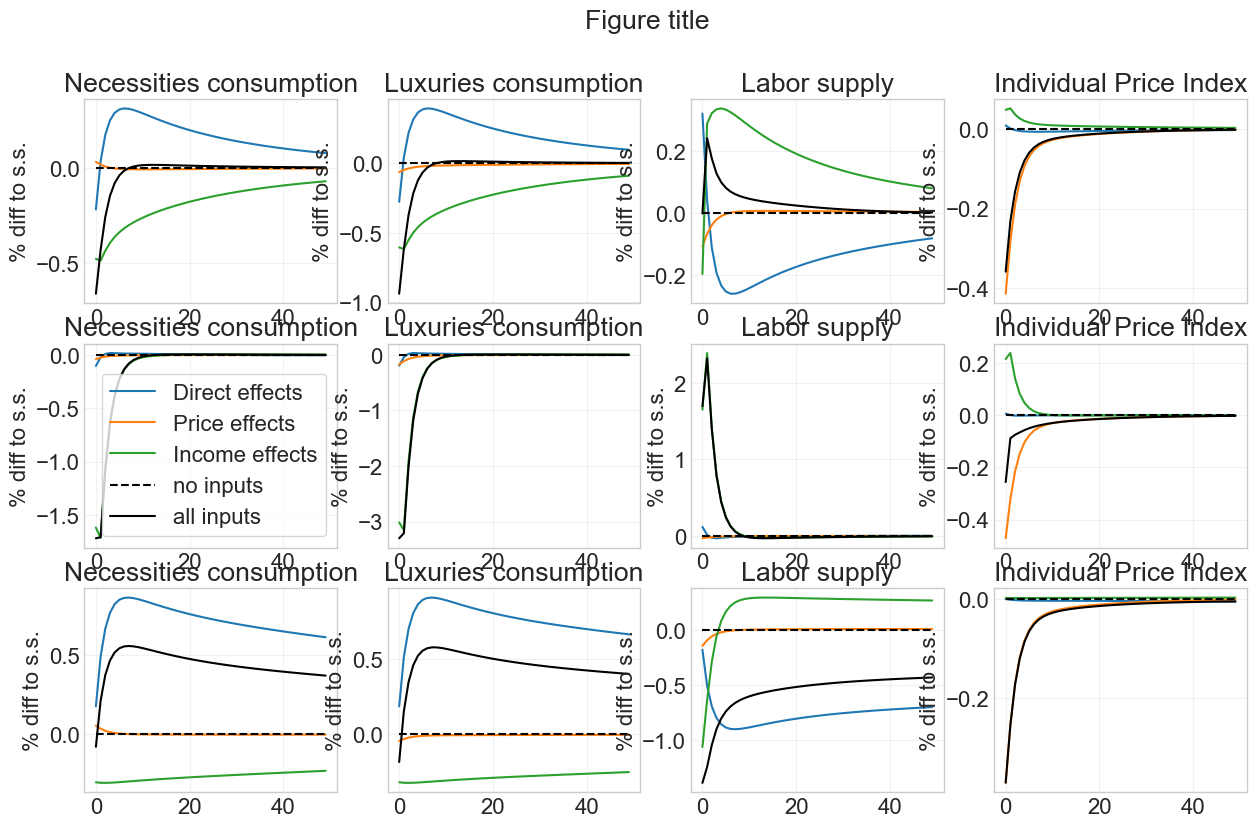

In [56]:
par.jump_istar = 0.01 # MP shock removed
#par.jump_pm_N     = 0.01*ss.Q # cost push shock
#par.jump_pm_N     = 0.0 # cost push shock
T_max = 50
model.find_transition_path(do_print=False) #all


### Plot stuff ### 
fig = plt.figure(figsize=(5*4,3*4),dpi=100)
fig.suptitle('Figure title')

ax = fig.add_subplot(3,4,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,4)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]/ss.P_hh-1)*100,ls=ls,color=color,label=label)
ax.set_title('Individual Price Index')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);


### POOREST ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(3,4,5)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]-path_alt_ss.C_N_hh[0,:T_max])/path_alt_ss.C_N_hh[0,:T_max]*100,ls=ls,color=color,label=label);
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

ax = fig.add_subplot(3,4,6)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]-path_alt_ss.C_L_hh[0,:T_max])/path_alt_ss.C_L_hh[0,:T_max]*100,ls=ls,color=color,label=label);
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,7)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]-path_alt_ss.ELL_hh[0,:T_max])/path_alt_ss.ELL_hh[0,:T_max]*100,ls=ls,color=color,label=label);
ax.set_title('Labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,8)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]-path_alt_ss.P_hh[0,:T_max])/path_alt_ss.P_hh[0,:T_max]*100,ls=ls,color=color,label=label);
ax.set_title('Individual Price Index')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);


### RICHEST ###

Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(3,4,9)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:T_max]-path_alt_ss.C_N_hh[0,:T_max])/path_alt_ss.C_N_hh[0,:T_max]*100,ls=ls,color=color,label=label);
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,10)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:T_max]-path_alt_ss.C_L_hh[0,:T_max])/path_alt_ss.C_L_hh[0,:T_max]*100,ls=ls,color=color,label=label);
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,11)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:T_max]-path_alt_ss.ELL_hh[0,:T_max])/path_alt_ss.ELL_hh[0,:T_max]*100,ls=ls,color=color,label=label);
ax.set_title('Labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(3,4,12)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,do_print=False,use_inputs=use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.P_hh[0,:T_max]-path_alt_ss.P_hh[0,:T_max])/path_alt_ss.P_hh[0,:T_max]*100,ls=ls,color=color,label=label);
ax.set_title('Individual Price Index')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);


Individual price index

In [ ]:
par.jump_istar = 0.0 # MP shock removed
par.jump_pm_N     = 0.01*ss.Q # cost push shock
T_max = 50
model.find_transition_path(do_print=False) #all

fig = plt.figure(figsize=(16,4),dpi=100)
### FIRST THE POOR WITHOUT ASSETS ### 

Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(1,3,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.P_hh[0,:50]-path_alt_ss.P_hh[0,:50])/path_alt_ss.P_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Hand-to-mouth: IPI')        
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

### AVERAGE ###

Dbeg = ss.Dbeg.copy()
ax = fig.add_subplot(1,3,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.P_hh[0,:50]-path_alt_ss.P_hh[0,:50])/path_alt_ss.P_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Average IPI')        
ax.set_ylabel('% diff to s.s.')

### WEALTHIEST ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(1,3,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.P_hh[0,:50]-path_alt_ss.P_hh[0,:50])/path_alt_ss.P_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Savers: IPI')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);



# 3-D GRAPHS YESSSS

In [ ]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
import sys
import pandas as pd
from scipy import optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 16
from mpl_toolkits.mplot3d import Axes3D

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#np.set_printoptions(threshold=sys.maxsize)

from HANKmodel import HANKModelClass
from HANKmodel_baseline import HANKModelClass_baseline

In [ ]:
model = HANKModelClass(name='two_sector')

par = model.par
ss = model.ss
path = model.path
sim = model.sim

T_max = 50

path_alt_list = []
path_alt_ss_list = []

model.par.alpha_N = 0.5
model.par.alpha_L = 0.5
#model.par.mu_L = 1.5
#model.par.mu_N = 1.5
#model.par.kappa_L = 0.125
#model.par.kappa_N = 0.125
#model.par.gamma_L = 0.5
#model.par.gamma_N = 0.5
model.find_ss()
model.compute_jacs()
T_max = 50
par.jump_pm_N     = 0.01*ss.Q # cost push shock
#par.jump_pm_N     = 0.0 # cost push shock
par.jump_istar     = 0.00    # MP shock
#par.jump_istar     = 0.0025 # MP shock
model.find_transition_path(do_print=False) #all

#or i in range(10):
#
#   Dbeg = ss.Dbeg.copy()
#   Dbeg = np.sum(Dbeg[0],axis=0) # sum over z --> return a 1d array (500,)
#   #Dbeg = Dbeg.to_list()
#   f = np.percentile(Dbeg,i+1) # returns value at the ith percentile
#   Dbeg.index(f)
#
#   #np.cumsum(np.sum(Dbeg[0],axis=0))
#   #Dbeg[:,i+1:,:] = 0.0 # zero every else than in first asset grid point
#   #Dbeg[:,:i,:] = 0.0 # zero every else than in first asset grid point
#   #Dbeg /= np.sum(Dbeg) # re-normalize
#
#   path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
#   path_alt = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
#
#   path_alt_list.append(path_alt)
#   path_alt_ss_list.append(path_alt_ss)
#
#


In [ ]:
for i in range(7):

    Dbeg = ss.Dbeg.copy()
    Dbeg[:,i+1:,:] = 0.0 # zero every else than in first asset grid point
    Dbeg[:,:i,:] = 0.0 # zero every else than in first asset grid point
    Dbeg /= np.sum(Dbeg) # re-normalize

    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 

    path_alt_list.append(path_alt)
    path_alt_ss_list.append(path_alt_ss)



T_max = 25

data_C_hh = np.empty((par.Nz,T_max))
data_C_N_hh = np.empty((par.Nz,T_max))
data_C_L_hh = np.empty((par.Nz,T_max))
data_ELL_hh = np.empty((par.Nz,T_max))
data_P_hh = np.empty((par.Nz,T_max))
data_U_hh = np.empty((par.Nz,T_max))
data_A_hh = np.empty((par.Nz,T_max))

for i in range(7):
    data_C_hh[i,:] = (path_alt_list[i].C_hh[0,:T_max]-path_alt_ss_list[i].C_hh[0,:T_max])/path_alt_ss_list[i].C_hh[0,:T_max]*100
    data_C_N_hh[i,:] = (path_alt_list[i].C_N_hh[0,:T_max]-path_alt_ss_list[i].C_N_hh[0,:T_max])/path_alt_ss_list[i].C_N_hh[0,:T_max]*100
    data_C_L_hh[i,:] = (path_alt_list[i].C_L_hh[0,:T_max]-path_alt_ss_list[i].C_L_hh[0,:T_max])/path_alt_ss_list[i].C_L_hh[0,:T_max]*100
    data_ELL_hh[i,:] = (path_alt_list[i].ELL_hh[0,:T_max]-path_alt_ss_list[i].ELL_hh[0,:T_max])/path_alt_ss_list[i].ELL_hh[0,:T_max]*100
    data_P_hh[i,:] = (path_alt_list[i].P_hh[0,:T_max]-path_alt_ss_list[i].P_hh[0,:T_max])/path_alt_ss_list[i].P_hh[0,:T_max]*100
    data_U_hh[i,:] = (path_alt_list[i].U_hh[0,:T_max]-path_alt_ss_list[i].U_hh[0,:T_max])/path_alt_ss_list[i].U_hh[0,:T_max]*-100
    data_A_hh[i,:] = (path_alt_list[i].A_hh[0,:T_max]-path_alt_ss_list[i].A_hh[0,:T_max])/path_alt_ss_list[i].A_hh[0,:T_max]*-100


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['legend.fontsize'] = 10


fig = plt.figure(figsize=(12,8),dpi=100)


#Consumption
length = data_C_hh.shape[1]
width = data_C_hh.shape[0]
x, y = np.meshgrid(np.arange(length), np.arange(width))
ax = fig.add_subplot(2,3,1, projection='3d')
surf = ax.plot_surface(x, y, data_C_hh,cmap=cm.RdBu)
ax.view_init(30, 250)
#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('Total consumption')        
#ax.set_zlabel('% Diff to s.s.')
ax.set_ylabel('Income type')
ax.set_xlabel('')

#Consumption necessities
length = data_C_N_hh.shape[1]
width = data_C_N_hh.shape[0]
x, y = np.meshgrid(np.arange(length), np.arange(width))
ax = fig.add_subplot(2,3,2, projection='3d')
surf = ax.plot_surface(x, y, data_C_N_hh,cmap=cm.RdBu)
ax.view_init(30, 250)
ax.set_title('Necessities consumption')        

#Consumption luxuries
length = data_C_L_hh.shape[1]
width = data_C_L_hh.shape[0]
x, y = np.meshgrid(np.arange(length), np.arange(width))
ax = fig.add_subplot(2,3,3, projection='3d')
surf = ax.plot_surface(x, y, data_C_L_hh,cmap=cm.RdBu)
ax.view_init(30, 250)
ax.set_title('Luxuries consumption')        

#Labor
length = data_ELL_hh.shape[1]
width = data_ELL_hh.shape[0]
x, y = np.meshgrid(np.arange(length), np.arange(width))
ax = fig.add_subplot(2,3,4, projection='3d')
surf = ax.plot_surface(x, y, data_ELL_hh,cmap=cm.coolwarm)
ax.view_init(30, 250)
ax.set_title('Labor supply')        

#IPI
length = data_P_hh.shape[1]
width = data_P_hh.shape[0]
x, y = np.meshgrid(np.arange(length), np.arange(width))
ax = fig.add_subplot(2,3,5, projection='3d')
surf = ax.plot_surface(x, y, data_P_hh,cmap=cm.coolwarm)
ax.view_init(30, 250)
ax.set_title('Individual price index')        


#Utility
length = data_U_hh.shape[1]
width = data_U_hh.shape[0]
x, y = np.meshgrid(np.arange(length), np.arange(width))
ax = fig.add_subplot(2,3,6, projection='3d')
surf = ax.plot_surface(x, y, data_U_hh,cmap=cm.RdBu)
ax.view_init(30, 250)
ax.set_title('Utility')        

plt.show()


## Monetary Policy experiements

Nondecomposed behavior for a subset of households. Here consumption for those with zero assets contra max assets.

In [ ]:
T_max = 50

path_alt_poor_list = []
path_alt_poor_ss_list = []

path_alt_rich_list = []
path_alt_rich_ss_list = []

path_alt_avg_list = []
path_alt_avg_ss_list = []

for i in range(5):
        #mod = model.copy()
        ss = model.ss
        model.par.phi = 1+i/4
        #model.par.alpha_N = 0.5
        #model.par.alpha_L = 0.5
        #model.par.mu_L = 1.5
        #model.par.mu_N = 1.5
        #model.par.kappa_L = 0.125
        #model.par.kappa_N = 0.125
        #model.par.gamma_L = 0.5
        #model.par.gamma_N = 0.5
        #model.par.c_bar = 0.05
        model.find_ss()
        #model.par.jump_istar = 0.0025 # 25 BP Monetary policy shock
        model.par.jump_pm_N     = 0.01*model.ss.Q # cost push shock
        model.compute_jacs()
        model.find_transition_path()
        
        # poor
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_poor_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        path_alt_poor_list.append(path_alt_poor)
        path_alt_poor_ss_list.append(path_alt_poor_ss)

        # rich
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_rich_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        path_alt_rich_list.append(path_alt_rich)
        path_alt_rich_ss_list.append(path_alt_rich_ss)

        # average
        Dbeg = ss.Dbeg.copy()

        path_alt_average_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_average = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        path_alt_avg_list.append(path_alt_average)
        path_alt_avg_ss_list.append(path_alt_average_ss)
#path_alts = []


In [ ]:
#path_alt_poor_list[0].C_hh[0,:T_max]

T_max = 20
vec_poor_p = []
vec_rich_p = []
vec_avg_p = []

columns = ['1.0','1.25','1.5','1.75','2.0']
rows = ['Hand-to-mouth','Aggregate','Savers']

for i,(a,b,c,d,e,f) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list,path_alt_rich_list,path_alt_rich_ss_list,path_alt_avg_list,path_alt_avg_ss_list)):
    
    vec_poor_p.append(np.mean(((a.P_hh[0,:T_max]-b.P_hh[0,:T_max])/b.P_hh[0,:T_max])/((path_alt_poor_list[2].P_hh[0,:T_max]-path_alt_poor_ss_list[2].P_hh[0,:T_max])/path_alt_poor_ss_list[2].P_hh[0,:T_max])-1))
    vec_rich_p.append(np.mean(((c.P_hh[0,:T_max]-d.P_hh[0,:T_max])/d.P_hh[0,:T_max])/((path_alt_rich_list[2].P_hh[0,:T_max]-path_alt_rich_ss_list[2].P_hh[0,:T_max])/path_alt_rich_ss_list[2].P_hh[0,:T_max])-1))
    vec_avg_p.append(np.mean(((e.P_hh[0,:T_max]-f.P_hh[0,:T_max])/f.P_hh[0,:T_max])/((path_alt_avg_list[2].P_hh[0,:T_max]-path_alt_avg_ss_list[2].P_hh[0,:T_max])/path_alt_avg_ss_list[2].P_hh[0,:T_max])-1))
    vecs = [vec_poor_p,vec_avg_p,vec_rich_p]
#path_alt_poor_list[0-5].[P,U,C,CN,CL,ELL]
df_paths = pd.DataFrame(data=vecs,columns=columns,index=rows).round(decimals=2)
print(df_paths.to_latex())


Show IRFs

In [ ]:
fig = plt.figure(figsize=(3*6,3*4),dpi=100)

ax = fig.add_subplot(3,3,1)
ax.set_title('Nominal interest rate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.i[0,:50]-b.i[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True)

ax = fig.add_subplot(3,3,2)
ax.set_title('Aggregate IPI')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)

ax = fig.add_subplot(3,3,3)
ax.set_title('Real Interest rate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.r[0,:50]-b.r[0,:50])*100)

ax = fig.add_subplot(3,3,4)
ax.set_title('Price: Necessity goods')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.p_N[0,:50]-b.p_N[0,:50])/b.p_N[0,:50]*100)
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,5)
ax.set_title('Price: Luxury goods')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.p_L[0,:50]-b.p_L[0,:50])/b.p_L[0,:50]*100)

ax = fig.add_subplot(3,3,6)
ax.set_title('Relative prices, Q')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.Q[0,:50]-b.Q[0,:50])/b.Q[0,:50]*100)

ax = fig.add_subplot(3,3,7)
ax.set_title('Consumption: Necessities')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.C_N_hh[0,:50]-b.C_N_hh[0,:50])/b.C_N_hh[0,:50]*100)
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,8)
ax.set_title('Consumption: Luxuries')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.C_L_hh[0,:50]-b.C_L_hh[0,:50])/b.C_L_hh[0,:50]*100)

ax = fig.add_subplot(3,3,9)
ax.set_title('Labor supply')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)


Plots of consumption decompositions by wealth levels:

In [ ]:
fig = plt.figure(figsize=(3*6,5*4),dpi=100)

#Consumption
ax = fig.add_subplot(5,3,1)
ax.set_title('Consumption: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,loc = "upper right")

ax = fig.add_subplot(5,3,2)
ax.set_title('Consumption: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(5,3,3)
ax.set_title('Consumption: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

#labor supply
ax = fig.add_subplot(5,3,4)
ax.set_title('Labor Supply: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

ax = fig.add_subplot(5,3,5)
ax.set_title('Labor Supply: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

ax = fig.add_subplot(5,3,6)
ax.set_title('Labor Supply: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)


#utility
ax = fig.add_subplot(5,3,7)
ax.set_title('Utility: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot((a.U_hh[0,:50]-b.U_hh[0,:50])/b.U_hh[0,:50]*-100)

ax = fig.add_subplot(5,3,8)
ax.set_title('Utility: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot((a.U_hh[0,:50]-b.U_hh[0,:50])/b.U_hh[0,:50]*-100)

ax = fig.add_subplot(5,3,9)
ax.set_title('Utility: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.U_hh[0,:50]-b.U_hh[0,:50])/b.U_hh[0,:50]*-100)

#IPI
ax = fig.add_subplot(5,3,10)
ax.set_title('Individual price index: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)

ax = fig.add_subplot(5,3,11)
ax.set_title('Individual price index: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)

ax = fig.add_subplot(5,3,12)
ax.set_title('Individual price index: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot((a.P_hh[0,:50]-b.P_hh[0,:50])/b.P_hh[0,:50]*100)


#IPI
ax = fig.add_subplot(5,3,13)
ax.set_title('Individual price index: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot(((a.P_hh[0,:25]-b.P_hh[0,:25])/b.P_hh[0,:25])/((path_alt_poor_list[2].P_hh[0,:25]-path_alt_poor_ss_list[2].P_hh[0,:25])/path_alt_poor_ss_list[2].P_hh[0,:25]))

ax = fig.add_subplot(5,3,14)
ax.set_title('Individual price index: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot(((a.P_hh[0,:25]-b.P_hh[0,:25])/b.P_hh[0,:25])/((path_alt_rich_list[2].P_hh[0,:25]-path_alt_rich_ss_list[2].P_hh[0,:25])/path_alt_rich_ss_list[2].P_hh[0,:25]))

ax = fig.add_subplot(5,3,15)
ax.set_title('Individual price index: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot(((a.P_hh[0,:25]-b.P_hh[0,:25])/b.P_hh[0,:25])/((path_alt_avg_list[2].P_hh[0,:25]-path_alt_avg_ss_list[2].P_hh[0,:25])/path_alt_avg_ss_list[2].P_hh[0,:25]))

### For the one-sector model:

In [ ]:
T_max = 50

os_path_alt_poor_list = []
os_path_alt_poor_ss_list = []

os_path_alt_rich_list = []
os_path_alt_rich_ss_list = []

os_path_alt_avg_list = []
os_path_alt_avg_ss_list = []

for i in range(5):
        #mod = model_baseline.copy()
        mod = model.copy()
        ss = mod.ss
        mod.par.c_bar = 0.0
        mod.par.alpha_hh = 0.41
        mod.par.phi = 1+i/4
        mod.find_ss()
        #model.par.jump_istar = 0.0025 # 25 BP Monetary policy shock
        #mod.par.jump_pm     = model.par.jump_pm_N # cost push shock
        mod.par.jump_pm_N     = model.par.jump_pm_N # cost push shock
        mod.compute_jacs()
        mod.find_transition_path()
        
        # poor
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_poor_ss = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_poor = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        os_path_alt_poor_list.append(path_alt_poor)
        os_path_alt_poor_ss_list.append(path_alt_poor_ss)

        # rich
        Dbeg = ss.Dbeg.copy()
        Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
        Dbeg /= np.sum(Dbeg) # re-normalize

        path_alt_rich_ss = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_rich = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        os_path_alt_rich_list.append(path_alt_rich)
        os_path_alt_rich_ss_list.append(path_alt_rich_ss)

        # average
        Dbeg = ss.Dbeg.copy()

        path_alt_average_ss = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)
        path_alt_average = mod.decompose_hh_path(Dbeg=Dbeg,use_inputs='all')

        os_path_alt_avg_list.append(path_alt_average)
        os_path_alt_avg_ss_list.append(path_alt_average_ss)
#path_alts = []


In [ ]:
fig = plt.figure(figsize=(3*6,3*4),dpi=100)

#consumption

ax = fig.add_subplot(3,3,1)
ax.set_title('Consumption: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(os_path_alt_poor_list,os_path_alt_poor_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,loc = "upper right")

ax = fig.add_subplot(3,3,2)
ax.set_title('Consumption: Savers')
for i,(a,b) in enumerate(zip(os_path_alt_rich_list,os_path_alt_rich_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,3)
ax.set_title('Consumption: Aggregate')
for i,(a,b) in enumerate(zip(os_path_alt_avg_list,os_path_alt_avg_ss_list)):
    ax.plot((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')


#labor
ax = fig.add_subplot(3,3,4)
ax.set_title('Labor Supply: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(os_path_alt_poor_list,os_path_alt_poor_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

ax = fig.add_subplot(3,3,5)
ax.set_title('Labor Supply: Savers')
for i,(a,b) in enumerate(zip(os_path_alt_rich_list,os_path_alt_rich_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)

ax = fig.add_subplot(3,3,6)
ax.set_title('Labor Supply: Aggregate')
for i,(a,b) in enumerate(zip(os_path_alt_avg_list,os_path_alt_avg_ss_list)):
    ax.plot((a.ELL_hh[0,:50]-b.ELL_hh[0,:50])/b.ELL_hh[0,:50]*100)
#utility
ax = fig.add_subplot(3,3,7)
ax.set_title('Utility: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(os_path_alt_poor_list,os_path_alt_poor_ss_list)):
    ax.plot((a.U_hh[0,:50]-b.U_hh[0,:50])/b.U_hh[0,:50]*-100)

ax = fig.add_subplot(3,3,8)
ax.set_title('Utility: Savers')
for i,(a,b) in enumerate(zip(os_path_alt_rich_list,os_path_alt_rich_ss_list)):
    ax.plot((a.U_hh[0,:50]-b.U_hh[0,:50])/b.U_hh[0,:50]*-100)

ax = fig.add_subplot(3,3,9)
ax.set_title('Utility: Aggregate')
for i,(a,b) in enumerate(zip(os_path_alt_avg_list,os_path_alt_avg_ss_list)):
    ax.plot((a.U_hh[0,:50]-b.U_hh[0,:50])/b.U_hh[0,:50]*-100)




### Showing the effect of the 2-sector set-up

In [ ]:
fig = plt.figure(figsize=(3*6,3*4),dpi=100)

#consumption - 1 sector
ax = fig.add_subplot(3,3,1)
ax.set_title('Consumption: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(os_path_alt_poor_list,os_path_alt_poor_ss_list)):
    ax.plot(((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(os_path_alt_poor_list[2].C_hh[0,:50]-os_path_alt_poor_ss_list[2].C_hh[0,:50])/os_path_alt_poor_ss_list[2].C_hh[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,loc = "upper right")

ax = fig.add_subplot(3,3,2)
ax.set_title('Consumption: Savers')
for i,(a,b) in enumerate(zip(os_path_alt_rich_list,os_path_alt_rich_ss_list)):
    ax.plot(((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(os_path_alt_rich_list[2].C_hh[0,:50]-os_path_alt_rich_ss_list[2].C_hh[0,:50])/os_path_alt_rich_ss_list[2].C_hh[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax = fig.add_subplot(3,3,3)

ax.set_title('Consumption: Aggregate')
for i,(a,b) in enumerate(zip(os_path_alt_avg_list,os_path_alt_avg_ss_list)):
    ax.plot(((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(os_path_alt_avg_list[2].C_hh[0,:50]-os_path_alt_avg_ss_list[2].C_hh[0,:50])/os_path_alt_avg_ss_list[2].C_hh[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')


#consumption - 2 sector
ax = fig.add_subplot(3,3,4)
ax.set_title('Consumption: Hand-to-Mouth')
for i,(a,b) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list)):
    ax.plot(((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(path_alt_poor_list[2].C_hh[0,:50]-path_alt_poor_ss_list[2].C_hh[0,:50])/path_alt_poor_ss_list[2].C_hh[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,loc = "upper right")

ax = fig.add_subplot(3,3,5)
ax.set_title('Consumption: Savers')
for i,(a,b) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list)):
    ax.plot(((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(path_alt_rich_list[2].C_hh[0,:50]-path_alt_rich_ss_list[2].C_hh[0,:50])/path_alt_rich_ss_list[2].C_hh[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,6)
ax.set_title('Consumption: Aggregate')
for i,(a,b) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list)):
    ax.plot(((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(path_alt_avg_list[2].C_hh[0,:50]-path_alt_avg_ss_list[2].C_hh[0,:50])/path_alt_avg_ss_list[2].C_hh[0,:50])*100,label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')





#consumption - 2 sector minus 1-sector 
ax = fig.add_subplot(3,3,7)
ax.set_title('Consumption: Hand-to-Mouth')
for i,(a,b,c,d) in enumerate(zip(path_alt_poor_list,path_alt_poor_ss_list,os_path_alt_poor_list,os_path_alt_poor_ss_list)):
    ax.plot((((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(path_alt_poor_list[2].C_hh[0,:50]-path_alt_poor_ss_list[2].C_hh[0,:50])/path_alt_poor_ss_list[2].C_hh[0,:50])*100 - ((c.C_hh[0,:50]-d.C_hh[0,:50])/d.C_hh[0,:50]-(os_path_alt_poor_list[2].C_hh[0,:50]-os_path_alt_poor_ss_list[2].C_hh[0,:50])/os_path_alt_poor_ss_list[2].C_hh[0,:50])*100),label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,loc = "upper right")

ax = fig.add_subplot(3,3,8)
ax.set_title('Consumption: Savers')
for i,(a,b,c,d) in enumerate(zip(path_alt_rich_list,path_alt_rich_ss_list,os_path_alt_rich_list,os_path_alt_rich_ss_list)):
    ax.plot((((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(path_alt_rich_list[2].C_hh[0,:50]-path_alt_rich_ss_list[2].C_hh[0,:50])/path_alt_rich_ss_list[2].C_hh[0,:50])*100 - ((c.C_hh[0,:50]-d.C_hh[0,:50])/d.C_hh[0,:50]-(os_path_alt_rich_list[2].C_hh[0,:50]-os_path_alt_rich_ss_list[2].C_hh[0,:50])/os_path_alt_rich_ss_list[2].C_hh[0,:50])*100),label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(3,3,9)
ax.set_title('Consumption: Aggregate')
for i,(a,b,c,d) in enumerate(zip(path_alt_avg_list,path_alt_avg_ss_list,os_path_alt_avg_list,os_path_alt_avg_ss_list)):
    ax.plot((((a.C_hh[0,:50]-b.C_hh[0,:50])/b.C_hh[0,:50]-(path_alt_avg_list[2].C_hh[0,:50]-path_alt_avg_ss_list[2].C_hh[0,:50])/path_alt_avg_ss_list[2].C_hh[0,:50])*100 - ((c.C_hh[0,:50]-d.C_hh[0,:50])/d.C_hh[0,:50]-(os_path_alt_avg_list[2].C_hh[0,:50]-os_path_alt_avg_ss_list[2].C_hh[0,:50])/os_path_alt_avg_ss_list[2].C_hh[0,:50])*100),label=f'phi ={1+i/4} ')
ax.set_ylabel('% diff to s.s.')



In [ ]:
#1 sector
#ax.set_title('Consumption: Aggregate')

print('1-sector, rich utility drop:')
print('Phi = 1',(os_path_alt_rich_list[0].U_hh[0,:5]-os_path_alt_rich_ss_list[0].U_hh[0,:5])/os_path_alt_rich_ss_list[0].U_hh[0,:5]*-100)
print('Phi = 2',(os_path_alt_rich_list[4].U_hh[0,:5]-os_path_alt_rich_ss_list[4].U_hh[0,:5])/os_path_alt_rich_ss_list[4].U_hh[0,:5]*-100)
print('2-Sector, rich utility drop:')
print('Phi = 1',(path_alt_rich_list[0].U_hh[0,:5]-path_alt_rich_ss_list[0].U_hh[0,:5])/path_alt_rich_ss_list[0].U_hh[0,:5]*-100)
print('Phi = 2',(path_alt_rich_list[4].U_hh[0,:5]-path_alt_rich_ss_list[4].U_hh[0,:5])/path_alt_rich_ss_list[4].U_hh[0,:5]*-100)

print('')

print('1-sector, poor utility drop:')
print('Phi = 1',(os_path_alt_poor_list[0].U_hh[0,:5]-os_path_alt_poor_ss_list[0].U_hh[0,:5])/os_path_alt_poor_ss_list[0].U_hh[0,:5]*-100)
print('Phi = 2',(os_path_alt_poor_list[4].U_hh[0,:5]-os_path_alt_poor_ss_list[4].U_hh[0,:5])/os_path_alt_poor_ss_list[4].U_hh[0,:5]*-100)
print('2-Sector, poor utility drop:')
print('Phi = 1',(path_alt_poor_list[0].U_hh[0,:5]-path_alt_poor_ss_list[0].U_hh[0,:5])/path_alt_poor_ss_list[0].U_hh[0,:5]*-100)
print('Phi = 2',(path_alt_poor_list[4].U_hh[0,:5]-path_alt_poor_ss_list[4].U_hh[0,:5])/path_alt_poor_ss_list[4].U_hh[0,:5]*-100)
print('')
print('I 2-sektor skal fordelen ved lav phi for fattige være større end i 1 sektor')
print('')

print('1-sector, total utility drop:')
print('Phi = 1',(os_path_alt_avg_list[0].U_hh[0,:5]-os_path_alt_avg_ss_list[0].U_hh[0,:5])/os_path_alt_avg_ss_list[0].U_hh[0,:5]*-100)
print('Phi = 2',(os_path_alt_avg_list[4].U_hh[0,:5]-os_path_alt_avg_ss_list[4].U_hh[0,:5])/os_path_alt_avg_ss_list[4].U_hh[0,:5]*-100)
print('2-Sector, total utility drop:')
print('Phi = 1',(path_alt_avg_list[0].U_hh[0,:5]-path_alt_avg_ss_list[0].U_hh[0,:5])/path_alt_avg_ss_list[0].U_hh[0,:5]*-100)
print('Phi = 2',(path_alt_avg_list[4].U_hh[0,:5]-path_alt_avg_ss_list[4].U_hh[0,:5])/path_alt_avg_ss_list[4].U_hh[0,:5]*-100)


#print('1-sector, poor labor increase:')
#print('Phi = 1',(os_path_alt_poor_list[0].ELL_hh[0,:5]-os_path_alt_poor_ss_list[0].ELL_hh[0,:5])/os_path_alt_poor_ss_list[0].ELL_hh[0,:5]*100)
#print('Phi = 2',(os_path_alt_poor_list[4].ELL_hh[0,:5]-os_path_alt_poor_ss_list[4].ELL_hh[0,:5])/os_path_alt_poor_ss_list[4].ELL_hh[0,:5]*100)
#print('2-Sector, poor labor increase:')
#print('Phi = 1',(path_alt_poor_list[0].ELL_hh[0,:5]-path_alt_poor_ss_list[0].ELL_hh[0,:5])/path_alt_poor_ss_list[0].ELL_hh[0,:5]*100)
#print('Phi = 2',(path_alt_poor_list[4].ELL_hh[0,:5]-path_alt_poor_ss_list[4].ELL_hh[0,:5])/path_alt_poor_ss_list[4].ELL_hh[0,:5]*100)
#(os_path_alt_avg_list[4].C_hh[0,:50]-os_path_alt_avg_ss_list[4].C_hh[0,:50])/os_path_alt_avg_ss_list[4].C_hh[0,:50]


## Find effect of parameter change

In [ ]:
#Ensure baseline model has push shock
model.par.jump_istar      = 0.00 # Monetary policy shock reset
model.par.jump_pm_N       = 0.01*ss.Q # cost push shock
model.par.varphi          = 1.5
#model.find_transition_path(do_print=False) #all

#CD loading checks
model_one = model.copy()
model_one.par.alpha_N = 0.5
model_one.par.alpha_L = 0.5
model_one.find_ss()
model_one.par.jump_pm_N     = 0.01*model_one.ss.Q #par.jump_pm_N # cost push shock
model_one.par.jump_istar     = model.par.jump_istar # Monetary policy shock
#model_two.par.jump_istar = 0.0025 # Monetary policy shock reset
model_one.compute_jacs()
model_one.find_transition_path()

#Mark-up checks
model_two = model.copy()
model_two.par.mu_L = 1.5
model_two.par.mu_N = 1.5
model_two.find_ss()
model_two.par.jump_pm_N     = 0.01*model_two.ss.Q #par.jump_pm_N # cost push shock
model_two.par.jump_istar     = model.par.jump_istar # Monetary policy shock
#model_two.par.jump_istar = 0.0025 # Monetary policy shock reset
model_two.compute_jacs()
model_two.find_transition_path()

#Price rigidity checks
model_three = model.copy()
model_three.par.kappa_L = 0.125
model_three.par.kappa_N = 0.125
model_three.find_ss()
model_three.par.jump_pm_N     = 0.01*model_three.ss.Q # cost push shock
model_three.par.jump_istar     = model.par.jump_istar # Monetary policy shock
#model_three.par.jump_istar = 0.0025 # Monetary policy shock reset
model_three.compute_jacs()
model_three.find_transition_path()

#Substitution elasticities check
model_four = model.copy()
model_four.par.gamma_L = 0.5
model_four.par.gamma_N = 0.5
model_four.find_ss()
model_four.par.jump_pm_N     = 0.01*model_four.ss.Q # cost push shock
model_four.par.jump_istar     = model.par.jump_istar # Monetary policy shock
#model_four.par.jump_istar = 0.0025 # Monetary policy shock reset
model_four.compute_jacs()
model_four.find_transition_path()


paths = ['pm_N','P_hh','p_L','p_N','Q','i','r','tau','C_N','C_L','N_N','N_L','M_N','M_L','w_N'] #Show all graphs
model.compare_IRFs([model,model_one,model_two,model_three,model_four],['Baseline calibration','alpha_s = 0.5','mu_$s$ = 1.5','kappa_s = 0.125','gamma_s = 0.5'],paths,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=3)

# Step 3b: Find linearized IRFs

In [ ]:
model.find_IRFs(do_print=True)

In [ ]:
paths = ['Y','N','N_hh','M_N','M_L','C_N_hh','C_L_hh','C','Q','tau','d_L','d_N','P_hh']
model.show_IRFs(paths,T_max=20,ncols=4,do_linear=True)

# Step 4. Simulation

In [ ]:
np.random.seed(1917)
model.simulate(do_print=True)

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('Nominal interest rate, i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('Inflation, pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('Real interest rate, r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('Aggregate consumption, C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

In [ ]:
model_sim()

Code from old monetary policy experiments

In [ ]:
#model_one   = model.copy()
#model_two   = model.copy()
#model_three = model.copy()
#model_four  = model.copy()
#model_five  = model.copy()
#
#model_list = [model_one,model_two,model_three,model_four,model_five]
##varphi_list = [1.0,1.25,1.50,1.75,2.0]
#
#for i, mod in enumerate(model_list):
#    mod.par.phi = 1+i/4 #Creates varphi-list
#    #mod.par.jump_pm     = par.jump_pm_N # cost push shock
#    mod.par.jump_pm_N     = mod.par.jump_pm_N # cost push shock
#    mod.par.jump_istar = mod.par.jump_istar # Monetary policy shock reset
#    mod.find_ss()
#    mod.compute_jacs()
#    mod.find_transition_path()

In [ ]:
#paths = [['r','pi','C_hh','ELL_hh'],['p_L','p_N','P_hh','i','r','C_N','C_L','ELL_hh','Q']]
#lvl_value = ['i','pi_L','pi_N','r','pi','tau'] #Show all push
#for j,p in enumerate(paths):
#
#    mod_list = []
#    phi_label_list = []
#    for i in range(4):
#        mod = model.copy()
#        mod.par.phi = 1+i/4
#        mod.find_ss()
#        mod.compute_jacs()
#        mod.find_transition_path()
#
#        mod_list.append(mod)
#        phi_label_list.append(f'phi={1+i/4}')
#
#    model.compare_IRFs(mod_list,phi_label_list,p,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=2+j)
#    
#    
#

In [ ]:
#paths = ['p_L','p_N','P_hh','i','r','C_N','C_L','ELL_hh','Q'] #Show all graphs
#model.compare_IRFs([model_one,model_two,model_three,model_four,model_five],['Phi = 1.0','Phi = 1.25','Phi = 1.5','Phi = 1.75','Phi = 2.0'],paths,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=3)

In [ ]:
#paths = ['r','pi','C_hh','ELL_hh'] #Show all graphs
#model.compare_IRFs([model_one,model_two,model_three,model_four,model_five],['Phi = 1.0','Phi = 1.25','Phi = 1.5','Phi = 1.75','Phi = 2.0'],paths,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=2)